In [ ]:
import os.path, json, io
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 20)

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data

from pyspark.sql.functions import lit, pandas_udf, PandasUDFType, col, udf
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DecimalType
from pyspark.sql import SparkSession
from pyspark import SparkContext
import findspark

import time

c:\users\kingsley\appdata\local\programs\python\python39\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
findspark.init()

In [ ]:
# Create SparkSession and attach Sparkcontext to it
spark = (SparkSession.builder
         .appName("data-science-project")
         .enableHiveSupport()
         .getOrCreate())

sc = spark.sparkContext

In [ ]:
#Load tree location point data
treeLoc_gdf = GeoDataFrame.from_file('treeloc150.shp')

In [ ]:
treeLoc_gdf.columns

Index(['Forest_ID', 'Plot_ID', 'Year_Estab', 'Azimuth', 'Distance', 'DBH',
       'Status', 'Field_HGT', 'YEAR', 'SP', 'TREE', 'HT', 'HCB', 'vols',
       '_list__', 'vols_ib', 'vols_merch', 'vols_ob', '_matched_r', 'TreeNum',
       'MU', 'Plot', 'BLC', 'STAND', 'Orientatio', 'LAYER', 'X2011_HT', 'Dist',
       'SUBQUAD', 'Year_Proje', 'Volume', 'Year_LastM', 'Tower', 'Plot_Azimu',
       'Plot_Dist', 'Tree_Azimu', 'Tree_Dist', 'X2009_DBH', 'X2015_Stat',
       'Block', 'Crown_Base', 'CR', 'Tree_ID', 'North_UTM_', 'East_UTM_Z',
       'COORDX', 'COORDY', 'ELEVATION', 'Azi', 'HT_2011', 'DeltaX', 'DeltaY',
       'Corrected_', '_x', '_y', 'SITEid', 'CRN_HT', 'CC', 'AZI_Cor',
       'OtherPlotN', 'TRT_YR', 'PlotX', 'PlotY', 'TreeX', 'TreeY', 'TRUE_AZI',
       'X', 'Y', 'Old_Plot', 'Plot_x', 'Plot_y', 'path', 'geometry'],
      dtype='object')

In [ ]:
treeLoc_gdf.drop(['Forest_ID', 'Plot_ID', 'Year_Estab', 'Azimuth', 'Distance',
       'Status', 'Field_HGT', 'YEAR', 'TREE', 'HT', 'HCB', 'vols',
       '_list__', 'vols_ib', 'vols_merch', 'vols_ob', '_matched_r', 'TreeNum',
       'MU', 'Plot', 'BLC', 'STAND', 'Orientatio', 'LAYER', 'X2011_HT', 'Dist',
       'SUBQUAD', 'Year_Proje', 'Volume', 'Year_LastM', 'Tower', 'Plot_Azimu',
       'Plot_Dist', 'Tree_Azimu', 'Tree_Dist', 'X2009_DBH', 'X2015_Stat',
       'Block', 'Crown_Base', 'CR', 'Tree_ID', 'North_UTM_', 'East_UTM_Z',
       'COORDX', 'COORDY', 'ELEVATION', 'Azi', 'HT_2011', 'DeltaX', 'DeltaY',
       'Corrected_', '_x', '_y', 'SITEid', 'CRN_HT', 'CC', 'AZI_Cor',
       'OtherPlotN', 'TRT_YR', 'PlotX', 'PlotY', 'TreeX', 'TreeY', 'TRUE_AZI',
       'X', 'Y', 'Old_Plot', 'Plot_x', 'Plot_y', 'path'], axis=1, inplace=True)

In [ ]:
treeLoc_gdf.plot()
plt.show()

In [ ]:
treeLoc_gdf = treeLoc_gdf.reset_index()
treeLoc_gdf = treeLoc_gdf.rename(columns={"index":"id"})

In [ ]:
treeLoc_gdf.head()

,level_0,id,DBH,SP,geometry,lon,lat
0,0,0,15.494,BF,POINT (-68.70115 44.91151),-68.701150,44.911512
1,1,1,16.764,BF,POINT (-68.70141 44.91144),-68.701413,44.911444
2,2,2,33.528,RO,POINT (-68.70126 44.91139),-68.701265,44.911388
3,3,3,22.098,WC,POINT (-68.70129 44.91139),-68.701286,44.911390
4,4,4,27.178,BF,POINT (-68.70141 44.91146),-68.701410,44.911456


In [ ]:
treeLoc_gdf.shape

(30558, 8)

In [ ]:
pol_gdf = GeoDataFrame.from_file('polygon150.shp')

In [ ]:
pol_gdf.head()

,OID_,Slope_Pct,Aspect,Tri_Index,Shape_Leng,Shape_Area,pol_name,geometry
0,0,1.657671,94.927049,4784,14593.730617,8.752798e+06,pol_4784,"POLYGON Z ((-69.24048 45.39453 277.00000, -69...."
1,0,0.821174,90.914513,4376,16592.326833,1.179528e+07,pol_4376,"POLYGON Z ((-69.20958 45.36813 233.00000, -69...."
2,0,0.826539,90.000000,4725,7871.364423,1.626414e+04,pol_4725,"POLYGON Z ((-69.19764 45.42309 226.00000, -69...."
3,0,11.158273,90.000000,4776,30.598047,4.015837e+01,pol_4776,"POLYGON Z ((-69.15121 45.40953 196.00000, -69...."
4,0,11.770466,71.439678,4388,2464.964341,5.501697e+03,pol_4388,"POLYGON Z ((-69.15110 45.40961 195.00000, -69...."


In [ ]:
pol_gdf.shape

(3884, 8)

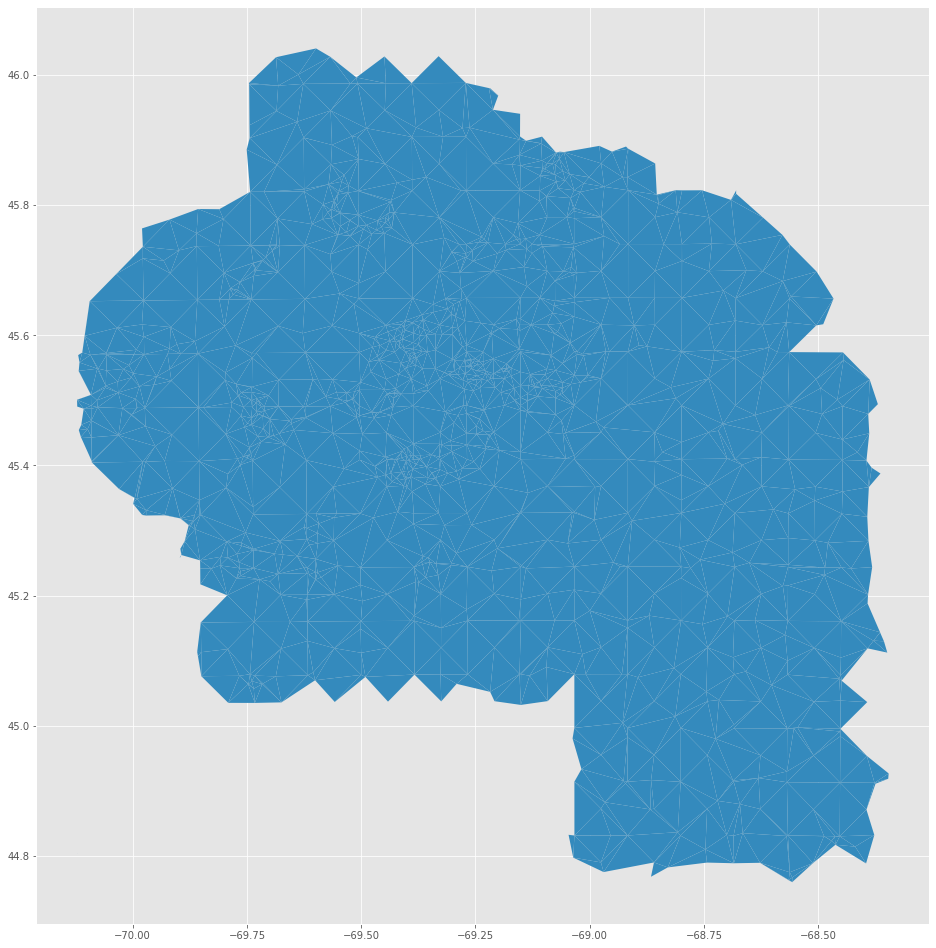

In [ ]:
pol_gdf.plot()
plt.show()

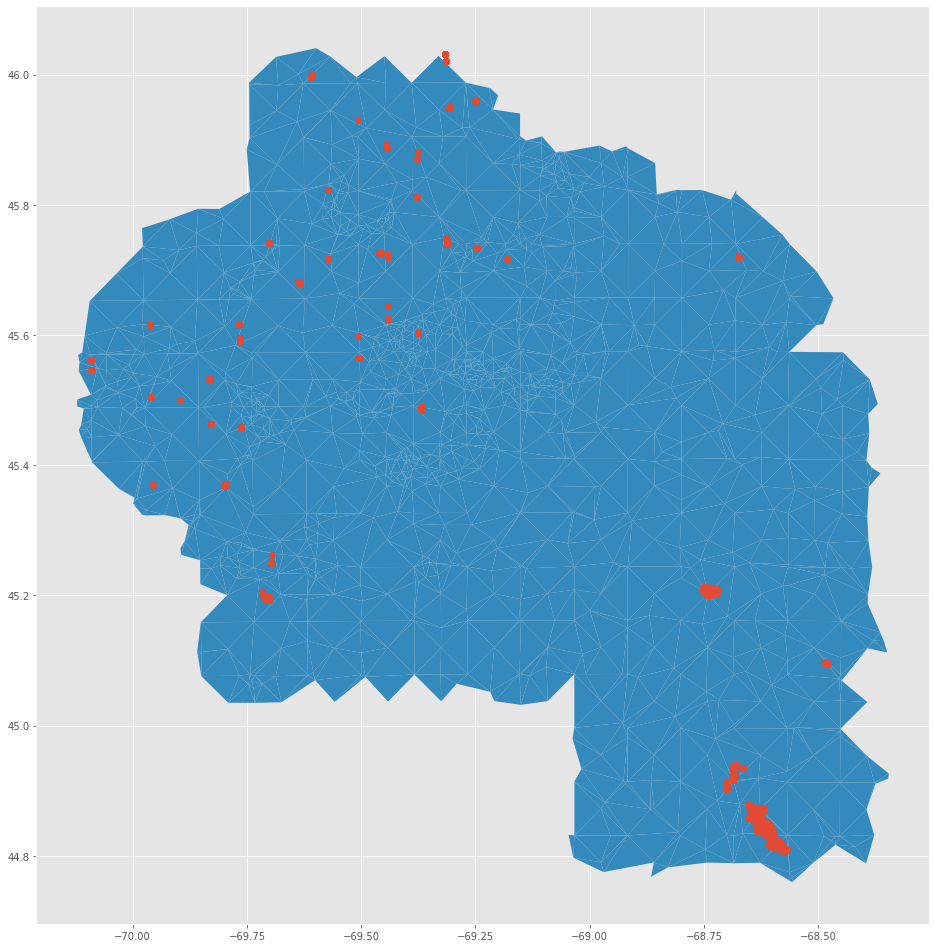

In [ ]:
plot = pol_gdf.plot()
plot = treeLoc_gdf.plot(ax=plot)
plt.show()

In [ ]:
# Spatial join in Geopandas
start_sj = time.time()
def geopd_join(pointdf, polydf, join_field):

    joined_gdf = gpd.sjoin(left_df=pointdf, right_df=polydf, how='left', predicate='within') 
    col_names = [col for col in joined_gdf.columns if col in pointdf.columns or col == join_field] 
    joined_gdf = joined_gdf[col_names]
    return joined_gdf

gpd_joined = geopd_join(treeLoc_gdf, pol_gdf, "pol_name")

print(gpd_joined.head())

end_sj = time.time()
run_time_sj = round(end_sj-start_sj, 3)
print("Srial Join Execution time:", run_time_sj)

   level_0  id     DBH  SP                    geometry        lon        lat  \
0        0   0  15.494  BF  POINT (-68.70115 44.91151) -68.701150  44.911512   
1        1   1  16.764  BF  POINT (-68.70141 44.91144) -68.701413  44.911444   
2        2   2  33.528  RO  POINT (-68.70126 44.91139) -68.701265  44.911388   
3        3   3  22.098  WC  POINT (-68.70129 44.91139) -68.701286  44.911390   
4        4   4  27.178  BF  POINT (-68.70141 44.91146) -68.701410  44.911456   

   pol_name  
0  pol_6780  
1  pol_6780  
2  pol_6780  
3  pol_6780  
4  pol_6780  
Srial Join Execution time: 0.215


In [ ]:
def pointGDF_to_PointSDF(gdf):
    gdf['lon'] = gdf['geometry'].x
    gdf['lat'] = gdf['geometry'].y
    temp_gdf = gdf.drop('geometry', axis=1)
    sdf = spark.createDataFrame(temp_gdf).cache()
    return sdf

In [ ]:
treeLoc_sdf = pointGDF_to_PointSDF(treeLoc_gdf)

In [ ]:
treeLoc_sdf.show()

+-------+---+------+---+------------------+------------------+
|level_0| id|   DBH| SP|               lon|               lat|
+-------+---+------+---+------------------+------------------+
|      0|  0|15.494| BF|-68.70114976003248| 44.91151153461431|
|      1|  1|16.764| BF|-68.70141330118324|44.911444255106424|
|      2|  2|33.528| RO|-68.70126492466339|  44.9113884905429|
|      3|  3|22.098| WC|-68.70128624192988| 44.91138954889125|
|      4|  4|27.178| BF| -68.7014100234459| 44.91145587603499|
|      5|  5|17.526| RS|-68.70135084021834|  44.9114047763833|
|      6|  6|11.938| BF| -68.7011744959788|44.911529466264966|
|      7|  7| 22.86| RM| -68.7011930477614|44.911543085803665|
|      8|  8|  12.7| BF|-68.70117352733989| 44.91151608806928|
|      9|  9|12.954| BF|-68.70139513112572| 44.91150680669145|
|     10| 10| 13.97| BF|-68.70117350161428| 44.91149797168712|
|     11| 11|10.414| BF|-68.70139199543938| 44.91149510349423|
|     12| 12|43.434| RO|-68.70136955817247| 44.91152781

In [ ]:
# Spatial join using parallel approach
start_pj = time.time()

def create_sjoin_udf(gdf_with_poly, join_column_name):
  def sjoin_settlement(x, y):
    gdf_temp = gpd.GeoDataFrame(data = [[x] for x in range(len(x))],geometry=gpd.points_from_xy(x,y),columns=['id'])
    settlement = gpd.sjoin(gdf_temp,gdf_with_poly,how='left', op='within')#.fillna(np.nan)
    return settlement.groupby('id').agg({'pol_name':lambda x: list(x)}).reset_index().sort_values(by='id').loc[:,join_column_name].astype('str')
  return pandas_udf(sjoin_settlement, returnType=StringType())

sjoin_udf = create_sjoin_udf(pol_gdf,'pol_name')

spark_joined = treeLoc_sdf.withColumn('pol_name',sjoin_udf(treeLoc_sdf.lon, treeLoc_sdf.lat))

spark_joined.show()

end_pj = time.time()
run_time_pj = round(end_pj-start_pj, 3)
print("Parallel Join Execution time:", run_time_pj)

+-------+---+------+---+------------------+------------------+------------+
|level_0| id|   DBH| SP|               lon|               lat|    pol_name|
+-------+---+------+---+------------------+------------------+------------+
|      0|  0|15.494| BF|-68.70114976003248| 44.91151153461431|['pol_6780']|
|      1|  1|16.764| BF|-68.70141330118324|44.911444255106424|['pol_6780']|
|      2|  2|33.528| RO|-68.70126492466339|  44.9113884905429|['pol_6780']|
|      3|  3|22.098| WC|-68.70128624192988| 44.91138954889125|['pol_6780']|
|      4|  4|27.178| BF| -68.7014100234459| 44.91145587603499|['pol_6780']|
|      5|  5|17.526| RS|-68.70135084021834|  44.9114047763833|['pol_6780']|
|      6|  6|11.938| BF| -68.7011744959788|44.911529466264966|['pol_6780']|
|      7|  7| 22.86| RM| -68.7011930477614|44.911543085803665|['pol_6780']|
|      8|  8|  12.7| BF|-68.70117352733989| 44.91151608806928|['pol_6780']|
|      9|  9|12.954| BF|-68.70139513112572| 44.91150680669145|['pol_6780']|
|     10| 10

In [ ]:
# Serial row by row intersection

start_si = time.time()

def gpd_intersection(point_geom):
  nmdf = poly_gdf.apply(lambda x: x['pol_name'] if x['geometry'].intersects(point_geom) else None, axis=1)
  idx = nmdf.first_valid_index()
  first_valid_value = nmdf.loc[idx] if idx is not None else None
  return first_valid_value

treeLoc_gdf['pol_name'] = treeLoc_gdf['geometry'].apply(gpd_intersection)

end_si = time.time()
run_time_si = round(end_si-start_si, 3)
print("Serial Intersection Execution time:", run_time_si)

Serial Intersection Execution time: 18038.668


In [ ]:
treeLoc_gdf.head()

,level_0,id,DBH,SP,geometry,lon,lat,pol_name
0,0,0,15.494,BF,POINT (-68.70115 44.91151),-68.701150,44.911512,pol_6780
1,1,1,16.764,BF,POINT (-68.70141 44.91144),-68.701413,44.911444,pol_6780
2,2,2,33.528,RO,POINT (-68.70126 44.91139),-68.701265,44.911388,pol_6780
3,3,3,22.098,WC,POINT (-68.70129 44.91139),-68.701286,44.911390,pol_6780
4,4,4,27.178,BF,POINT (-68.70141 44.91146),-68.701410,44.911456,pol_6780


In [ ]:
# Parallel row by row intersection intersection

start_pi = time.time()
sc.broadcast(poly_gdf)

def spark_intersection(longitude, latidute):
    mgdf = poly_gdf.apply(lambda x: x['pol_name'] if x['geometry'].intersects(Point(longitude, latidute)) else None, axis=1)
    idx = mgdf.first_valid_index()
    first_valid_value = mgdf.loc[idx] if idx is not None else None
    return str(first_valid_value)

find_intersection_udf = udf(spark_intersection, StringType())

spark_inter = treeLoc_sdf.withColumn("pol_name", find_intersection_udf(col("lon"), col("lat")))

spark_inter.show()

end_pi = time.time()
run_time_pi = round(end_pi-start_pi, 3)
print("Parallel Intersection Execution time:", run_time_pi)

+-------+---+------+---+------------------+------------------+--------+
|level_0| id|   DBH| SP|               lon|               lat|pol_name|
+-------+---+------+---+------------------+------------------+--------+
|      0|  0|15.494| BF|-68.70114976003248| 44.91151153461431|pol_6780|
|      1|  1|16.764| BF|-68.70141330118324|44.911444255106424|pol_6780|
|      2|  2|33.528| RO|-68.70126492466339|  44.9113884905429|pol_6780|
|      3|  3|22.098| WC|-68.70128624192988| 44.91138954889125|pol_6780|
|      4|  4|27.178| BF| -68.7014100234459| 44.91145587603499|pol_6780|
|      5|  5|17.526| RS|-68.70135084021834|  44.9114047763833|pol_6780|
|      6|  6|11.938| BF| -68.7011744959788|44.911529466264966|pol_6780|
|      7|  7| 22.86| RM| -68.7011930477614|44.911543085803665|pol_6780|
|      8|  8|  12.7| BF|-68.70117352733989| 44.91151608806928|pol_6780|
|      9|  9|12.954| BF|-68.70139513112572| 44.91150680669145|pol_6780|
|     10| 10| 13.97| BF|-68.70117350161428| 44.91149797168712|po